In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
from tqdm import tqdm

import uproot
import awkward as ak
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from ad.models.hgmm import HierarchicalGMM
from scipy.stats import norm

params = ["Track.PT", "Track.Eta", "Track.Phi", "Track.D0", "Track.DZ"]

fname = "/sdf/home/y/youngsam/data/atlas/pileup_generation/10k_pileup.root"
file = uproot.open(fname)["Delphes"]
f = file.arrays(params + ["Track.vxTruth"])
track_pileup_ids = f["Track.vxTruth"][:, 0]

new_arr = []
touched_pileup_ids = set()
for track, pileup_id in zip(f, track_pileup_ids):
    if pileup_id in touched_pileup_ids:
        continue
    touched_pileup_ids.add(pileup_id)
    new_arr.append(track)
array = ak.Array(new_arr)

def filter_parameters(array):
    # array = array[array["Track.PT"] > 0.5]
    # array = array[abs(array["Track.Eta"]) < 5]
    # array = array[abs(array["Track.slogDZ"]) < 5]
    # array = array[abs(array["Track.slogD0"]) < 7]
    array = array[ak.num(array["Track.PT"], axis=1) > 2]
    return array

array = filter_parameters(array)
sum(ak.num(array["Track.PT"], axis=1))

66954

In [3]:
hgmm = HierarchicalGMM(
    params=["Track.logPT", "Track.Eta", "Track.DZ", "Track.D0"],
    event_n_components=75,
    event_reg_covar=1e-6,
    global_reg_covar=1e-6,
    event_init_params="random_from_data",
    seed=123,
)
hgmm.fit(array)

INFO:HGMM:Fitting event-level GMMs
100%|██████████| 765/765 [00:45<00:00, 16.84it/s]
INFO:HGMM:Fit n_track_per_event estimator


In [9]:
################################
#    Re-fit event-level GMM    #
################################
data = hgmm._total_data
scaled_data = hgmm.scaler.transform(data)

hgmm.event_gmm = GaussianMixture(
    75, covariance_type="full", reg_covar=1e-6, init_params="random_from_data"
).fit(scaled_data)

Plot GMM distribution corner plot

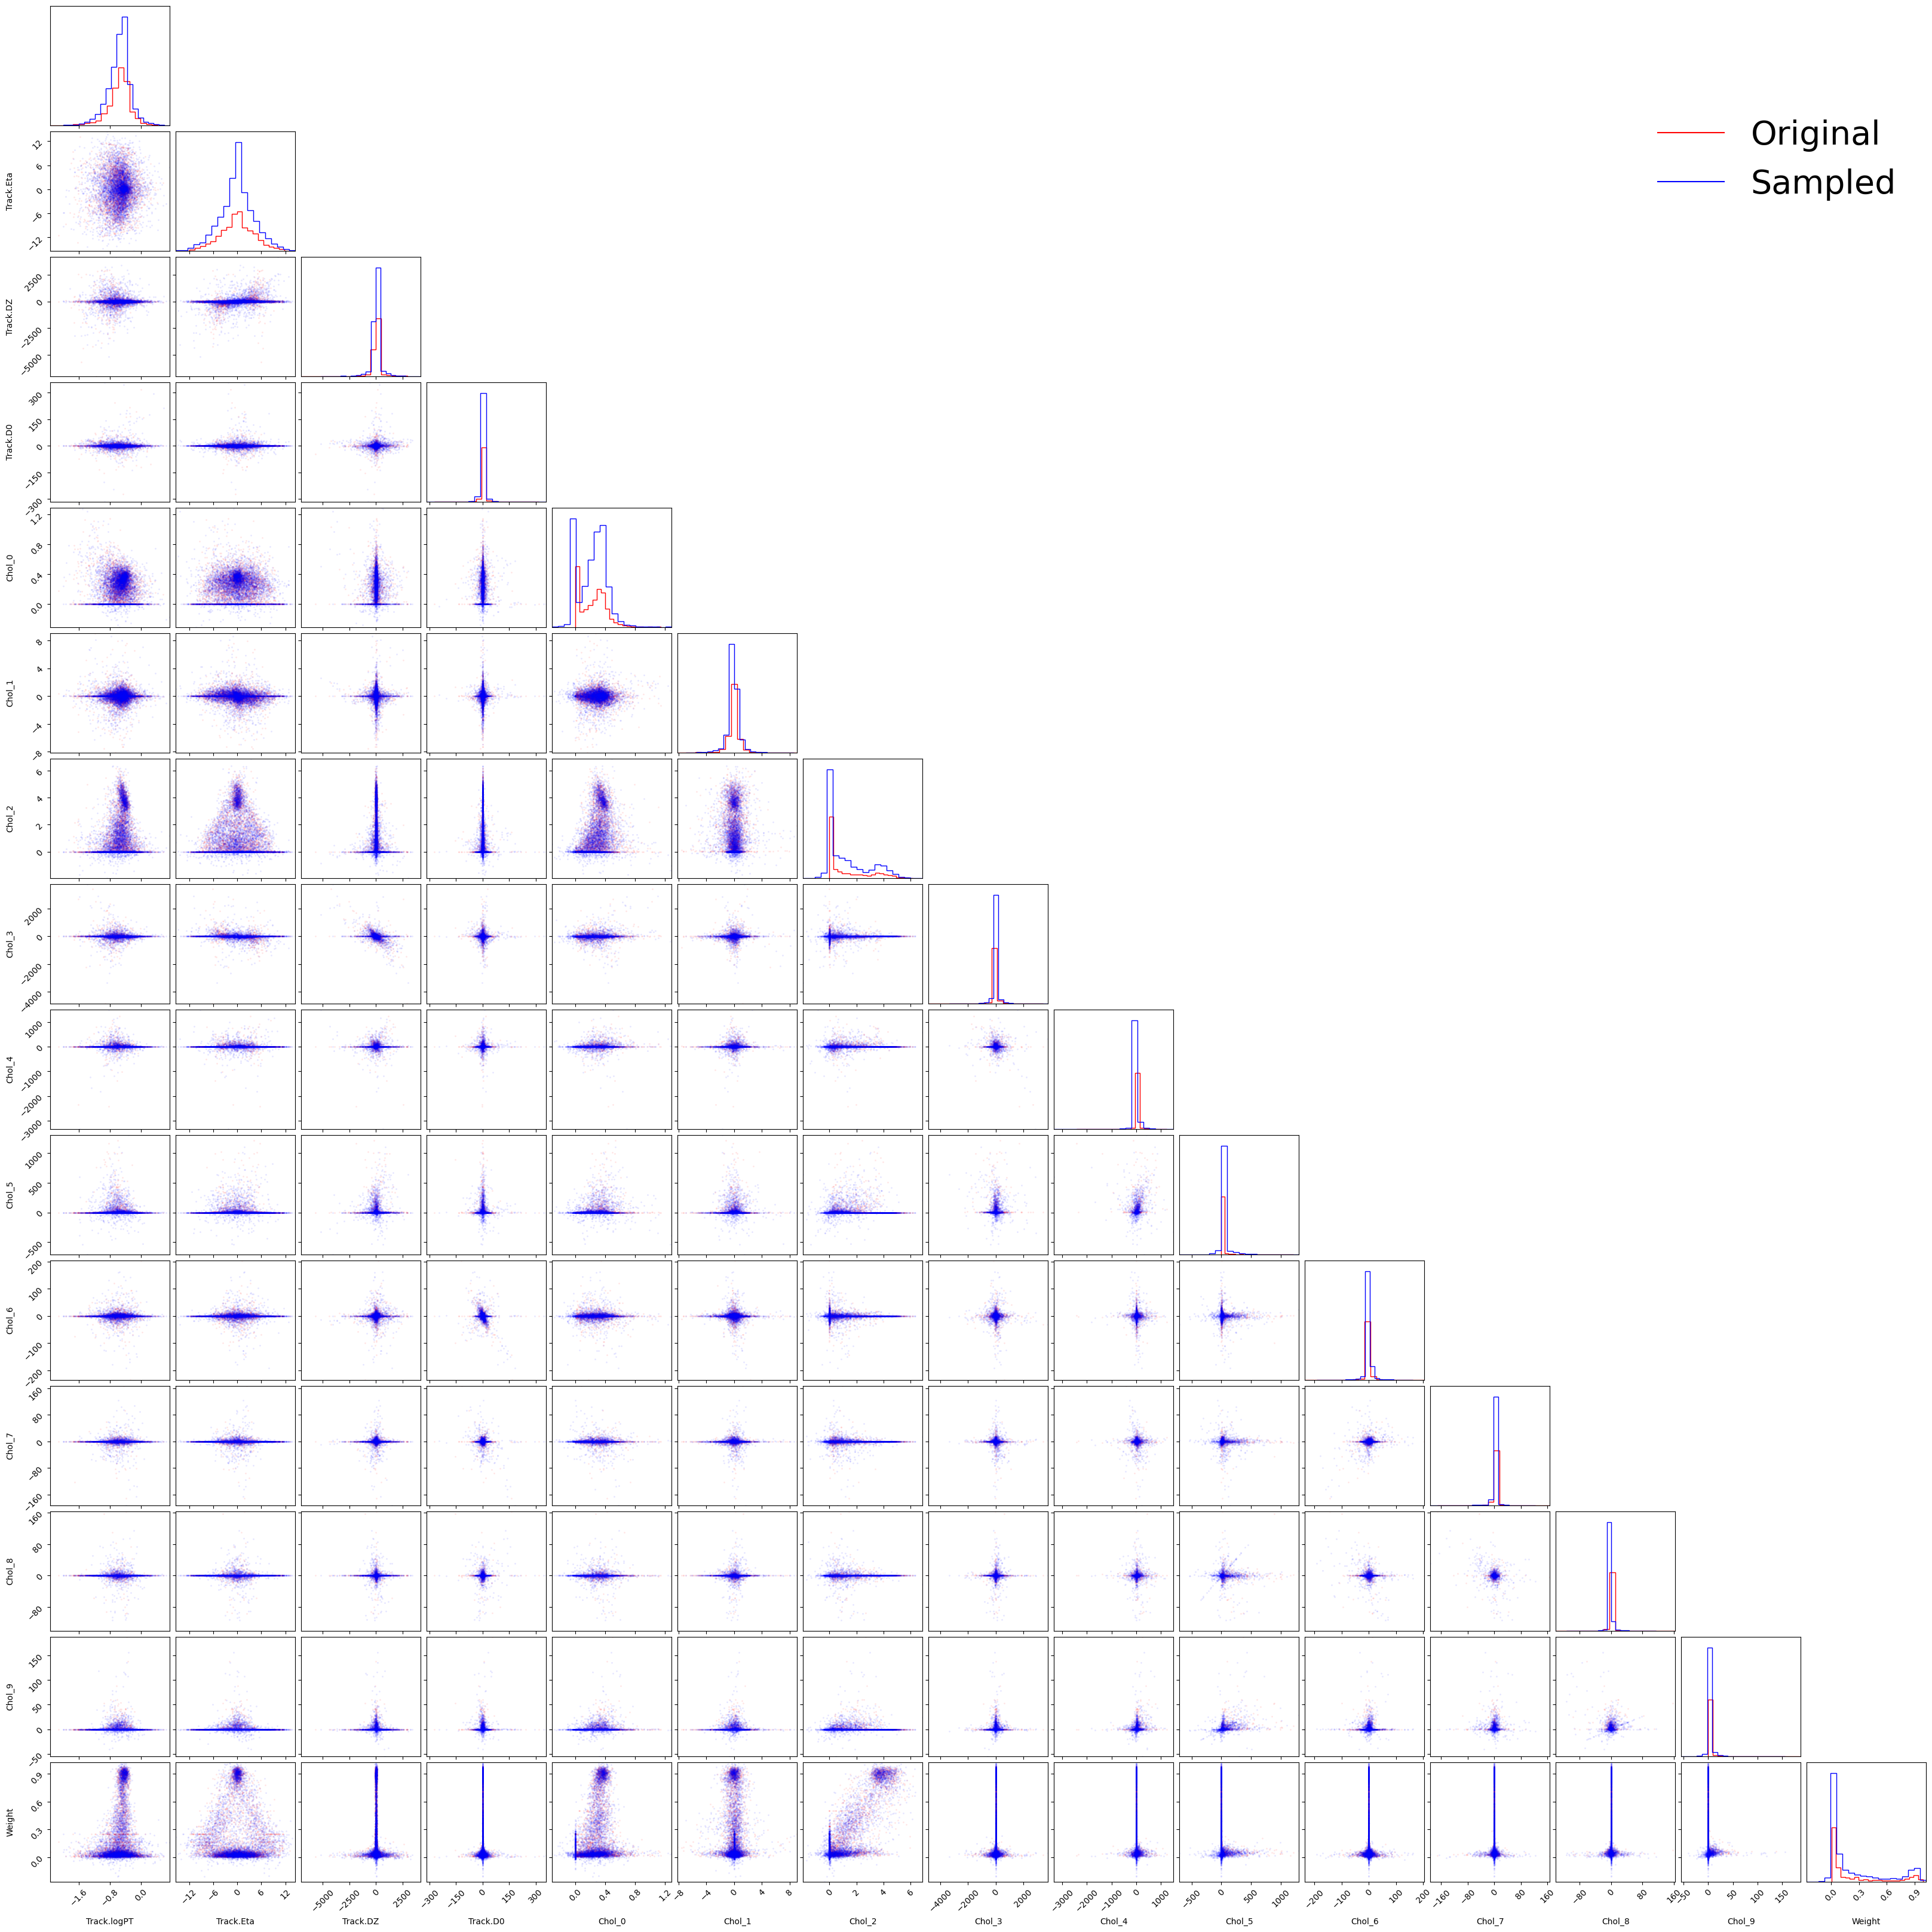

In [10]:
from corner import corner
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import logging

logging.getLogger().setLevel(logging.ERROR)

params = ["Track.logPT", "Track.Eta", "Track.DZ", "Track.D0"]
total_data_untrans = hgmm._total_data.copy()

fig = corner(
    total_data_untrans[:,],
    color="red",
    histogram_kwargs={"density": True},
    labels=[p for p in params]
    + [f"Chol_{i}" for i in range(len(params) * (len(params) + 1) // 2)]
    + ["Weight"],
    plot_contours=False,
    no_fill_contours=True,
    plot_density=False,
)

sample_scaled = hgmm.event_gmm.sample(2*hgmm._total_data.shape[0])[0]
# sampled_scaled = hgmm.pca.inverse_transform(sampled_pca)
inverse_scaled = hgmm.scaler.inverse_transform(sample_scaled)
# inverse_scaled[:, -1] = inv_logit(inverse_scaled[:, -1])

fig = corner(
    inverse_scaled,
    fig=fig,
    color="blue",
    histogram_kwargs={"density": True},
    labels=[p for p in params]
    + [f"Chol_{i}" for i in range(len(params) * (len(params) + 1) // 2)]
    + ["Weight"],
    plot_contours=False,
    no_fill_contours=True,
    plot_density=False,
)
plt.legend(
    handles=[
        Line2D([0], [0], color="red", label="Original"),
        Line2D([0], [0], color="blue", label="Sampled"),
    ],
    frameon=False,
    bbox_to_anchor=(1, len(fig.axes) ** 0.5),
    loc="upper right",
    fontsize=40,
)

plt.show()

Plot $p_T,\eta,d_z,d_0$ distribution marginalized over 1000 events and compare it to the original MinBias.pileup distribution

In [19]:
events = hgmm.sample(1000, clip_covar=1e-2)

In [20]:
params = ["Track.PT", "Track.Eta", "Track.DZ", "Track.D0"]
synthesized_sample = np.array([ak.ravel(events[param]).to_numpy() for param in params]).T
original_sample = np.array([ak.ravel(array[param]).to_numpy() for param in params]).T

/sdf/home/y/youngsam/miniforge3/lib/python3.10/site-packages/corner/core.py:922: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  return ax.set_ylim(new_ylim)
/sdf/home/y/youngsam/miniforge3/lib/python3.10/site-packages/corner/core.py:922: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  return ax.set_ylim(new_ylim)
/sdf/home/y/youngsam/miniforge3/lib/python3.10/site-packages/corner/core.py:922: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  return ax.set_ylim(new_ylim)
/sdf/home/y/youngsam/miniforge3/lib/python3.10/site-packages/corner/core.py:922: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  return ax.set_ylim(new_ylim)
/sdf/home/y/youngsam/miniforge3/lib/python3.10/site-packages/corner/core.py:922: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  return ax.set_ylim(new_ylim)
/sdf/home/y/youngsam

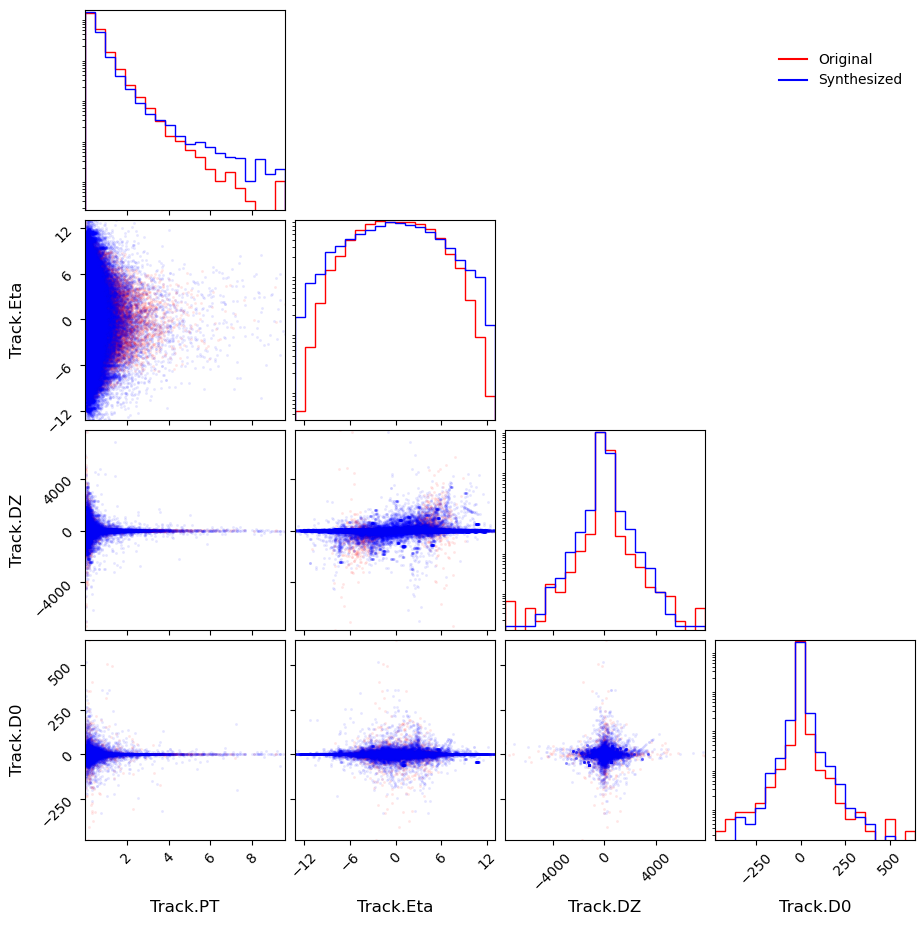

In [21]:
from matplotlib.lines import Line2D
from corner import corner
import logging

logging.getLogger().setLevel(logging.ERROR)

ranges = []
for param in params:
    ranges.append((ak.min(array[param]), ak.max(array[param])))
fig = corner(
    original_sample[::1],
    color="red",
    plot_contours=False,
    no_fill_contours=True,
    plot_density=False,
    range=ranges,
    labels=params,
    label_kwargs={"fontsize": 12},
    hist_kwargs={"density": True, "log": True},
)
fig = corner(
    synthesized_sample[::1],
    fig=fig,
    color="blue",
    plot_contours=False,
    no_fill_contours=True,
    plot_density=False,
    range=ranges,
    labels=params,
    label_kwargs={"fontsize": 12},
    hist_kwargs={"density": True, "log": True},
)


plt.legend(
    handles=[
        Line2D([0], [0], color="red", label="Original"),
        Line2D([0], [0], color="blue", label="Synthesized"),
    ],
    frameon=False,
    bbox_to_anchor=(1, len(fig.axes) ** 0.5),
    loc="upper right",
)

plt.show()

In [51]:
import pickle
with open("thgmm.pkl", "rb") as f:
    thgmm = pickle.load(f)

In [18]:
_display_plot_rcParams = {
    "figure.figsize": [10, 7],
    "figure.dpi": 100,
    "xtick.top": True,
    "xtick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.right": True,
    "ytick.direction": "in",
    "ytick.minor.visible": True,
    "font.size": 12,
    "mathtext.default": "regular",
    "font.family": "DejaVu Serif",
}
plt.rcParams.update(_display_plot_rcParams)

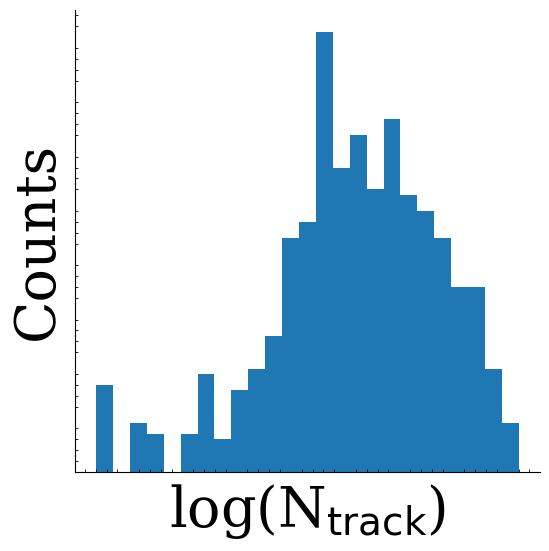

In [39]:
import awkward as ak


plt.figure(figsize=(6, 6), dpi=100)
plt.hist(np.log10(ak.ravel(ak.num(thgmm._X["Track.PT"], axis=1))), bins=25)
plt.xlabel("log($N_\\text{track}$)", fontsize=40)
plt.ylabel("Counts", fontsize=40)

# remove top and right axes
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# turn off all ticks
plt.gca().xaxis.tick_bottom()
plt.gca().yaxis.tick_left()
plt.tick_params(
    top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False
)


# remove face color
plt.gca().set_facecolor("none")
# plt.xlim(
#     0,
# )
# remove all background color
plt.savefig("num_tracks.png", dpi=300, bbox_inches="tight")
plt.show()

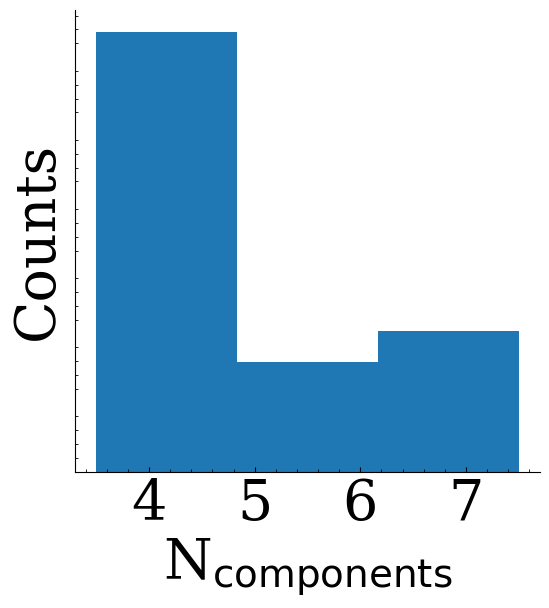

In [50]:
import awkward as ak


plt.figure(figsize=(6, 6), dpi=100)

vals, freq = thgmm.n_components_per_event
n_components = np.random.choice(vals, p=freq, size=1000)

plt.hist(n_components, bins=3)
plt.xlabel("$N_\\text{components}$", fontsize=40)
plt.ylabel("Counts", fontsize=40)

# remove top and right axes
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# turn off all ticks
plt.gca().xaxis.tick_bottom()
plt.gca().yaxis.tick_left()
plt.tick_params(
    top=False, bottom=True, left=False, right=False, labelleft=False, labelbottom=True
)
# set xticks to [1,2,3,4]
plt.xticks([3.5, 4.5, 5.5, 6.5], [4, 5, 6, 7], fontsize=40)

# remove face color
plt.gca().set_facecolor("none")
# plt.xlim(
#     0,
# )
# remove all background color
plt.savefig("num_tracks.png", dpi=300, bbox_inches="tight")
plt.show()

#### Create a ton of simulated pileup events across a couple nodes

In [1]:
import dask
import numpy as np
import awkward as ak
import pickle

# Generating pileup on the cluster

with open("thgmm.pkl", "rb") as f:
    thgmm = pickle.load(f)


def select(X):
    # PT > 0.5
    X = X[X["Track.PT"] > 0.5]

    # |Eta| < 5
    X = X[abs(X["Track.Eta"]) < 5]
    return X


def simulate_pileup(mu=60):
    n_events = np.random.poisson(mu)
    events = thgmm.sample(n_events)
    events = select(events)
    params = ["Track.PT", "Track.Eta", "Track.Phi", "Track.DZ", "Track.D0"]
    # raveled = ak.Array({p: ak.ravel(events[p]).to_list() for p in params})
    raveled = ak.Array({p: ak.ravel(events[p]) for p in params})
    return raveled


@dask.delayed
def run_simulation(index):
    output = simulate_pileup(mu=60)
    ak.to_parquet(
        output,
        f"/sdf/home/y/youngsam/data/atlas/pileup_generation/parquet/pileup_{index}.parquet",
    )
    return index

In [2]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = SLURMCluster(
    cores=32, memory="64GB", walltime="02:00:00",
    account="atlas:usatlas", queue="roma", name="pileup", n_workers=32
)

/sdf/home/y/youngsam/miniforge3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35901 instead
  warnings.warn(


In [3]:
client = Client(cluster)

In [12]:
files = !ls /sdf/home/y/youngsam/data/atlas/pileup_generation/parquet

already_done = []
for file in files:
    index = int(file.split("_")[-1].split(".")[0])
    already_done.append(index)

In [13]:
to_do = set(range(400_000)) - set(already_done)
len(to_do)

21

In [14]:
results = [run_simulation(i) for i in to_do]

In [15]:
results = dask.compute(*results)